# Football 데이터분석

## 아이디어

- 경기 결과(승/패/무)에 대해 예측하는 모델
    - 로지스틱 회귀
    - 그래디언트 부스트
    - 나이브 베이즈
    - 다층 퍼셉트론(MLP)
- 독립변수로 아래 항목들을 포함한 게임 데이터 활용
    - 각 팀의 직전 5개 게임 평균 골 횟수
    - 각 팀의 직전 5개 게임 평균 어시스트 수
    - 각 팀의 직전 5개 게임 평균 반칙 횟수
    - 각 팀의 포메이션
- 아래 데이터셋 활용
    - games
    - game_event
    - player_valuations

## EDA for each dataset

In [330]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [664]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import anderson
import os

### DATA 불러오기

In [332]:
main_folder = r'C:/Users/LG/PythonDataWorkspace/DATA STUDY/240222 FOOTBAL DATA/DATA'

file_list = os.listdir(main_folder)

file_names = []
for name in file_list:
    parts = name.split(".")
    file_names.append(parts[0])

for i in range(len(file_list)):
    globals()[file_names[i]] = pd.read_csv(main_folder + "/" + file_list[i])
    
file_names

C:\Users\LG\AppData\Local\Temp\ipykernel_16332\3831399221.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[file_names[i]] = pd.read_csv(main_folder + "/" + file_list[i])


['appearances',
 'clubs',
 'club_games',
 'competitions',
 'games',
 'game_events',
 'game_lineups',
 'players',
 'player_valuations']

### EDA 함수

#### 결측치 확인

In [333]:
# 결측치 확인
def null_check(df):
    
    print('[ 결측치 확인 ]')
    print('')
    print('-' * 35)

    for column in df.columns:
        if df[column].isna().sum() == 0:
            pass
        else:
            print(column + " 결측치 비율:")
            print(round(df[column].isna().sum() / len(df) * 100, 2), "%")
            print('-' * 35)

    msno.matrix(df = df, figsize = (5, 5), color = (0.8, 0.5, 0.2), fontsize = 7);

#### 범주형 자료 value별 비율 확인

In [546]:
# 범주형자료 value별 비율 확인1
def pie(data_column): #dataset.result
    
    pie_list = data_column.value_counts()

    labels = []
    ratio = []

    for label in pie_list.index:    
        labels.append(label)
    for numbers in pie_list.values:
        ratio.append(numbers)

    plt.figure(figsize = (8, 6))
    wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    colors = ['#ff9999', '#ffc000', '#c0c0c0']

    plt.rc('font', family = 'Malgun Gothic')
    plt.title(data_column.name + ' 비율', size = 20)
    plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle = 260, 
            counterclock = False, colors = colors,
            wedgeprops = wedgeprops, textprops = {'fontsize': 15})
    plt.legend(labels)
    plt.show()

In [ ]:
# 범주형자료 value별 비율 확인2(값이 많은 경우)
def bar(data_column):
    
    bar_list = data_column.value_counts()

    labels = []
    numbers = []
    ratio = []
    
    for label in bar_list.index:    
        labels.append(label)
    for number in bar_list.values:
        numbers.append(number)
    for number in numbers:
        ratio.append(round(number / sum(numbers) * 100, 1))
    
    plt.figure(figsize = (14, 8))
    plt.bar(labels, ratio, width = 0.5, color = '#d2b48c', label = data_column.name)
    plt.rc('font', family = 'Malgun Gothic')
    plt.title(data_column.name + ' 비율', size = 20)
    plt.xticks(rotation=90)
    plt.xlabel("values", size = 15)
    plt.ylabel("percentage", size = 15)
    
    for x, value in enumerate(ratio):
        if value > 0.5:
            plt.text(x, value*1.01, value)
        else:
            pass
    
    plt.show()

#### 수치형 데이터 분포 확인

In [665]:
def dist(data_column):

    sns.set_theme(style="darkgrid")

    data = data_column.dropna().values.tolist()

    plt.rc('font', family = 'Malgun Gothic')
    plt.figure(figsize = (8, 6))
    sns.distplot(data, kde = False, fit=norm)
    plt.title(data_column.name + " 분포", size = 20)
    plt.show();

#### 정규성 검정

In [663]:
def norm_check(data, columns):
    
    print("[column별 샤피로 윌크 검정]")
    print("")
    
    for column in columns:

        sha_stat, sha_pvalue = shapiro(data[column])
        and_result = anderson(data[column])       
        
        print('-'*40)
        print("")
        print(column + " 검정")
        print("샤피로-윌크 검정 통계량:", sha_stat)
        print("p-값:", sha_pvalue)
        print("")

#### 이상치 확인

In [682]:
def outlier(data):
    
    sns.set_theme(style="darkgrid")
    rcParams['figure.figsize'] = 12,8
    ax = sns.boxplot(data=data, palette="Pastel1")
    plt.title("Outliers for each column")
    plt.show();

### players valuation data

In [334]:
# 데이터 확인
player_value = player_valuations.drop(['player_club_domestic_competition_id'], axis = 1)
player_value

,player_id,date,market_value_in_eur,current_club_id
0,405973,2000-01-20,150000,3057
1,342216,2001-07-20,100000,1241
2,3132,2003-12-09,400000,126
3,6893,2003-12-15,900000,984
4,10,2004-10-04,7000000,398
...,...,...,...,...
465316,1201294,2024-02-12,50000,3840
465317,551505,2024-02-21,7000000,969
465318,754037,2024-02-21,5000000,2410
465319,763079,2024-02-21,2000000,826


[ 결측치 확인 ]

-----------------------------------


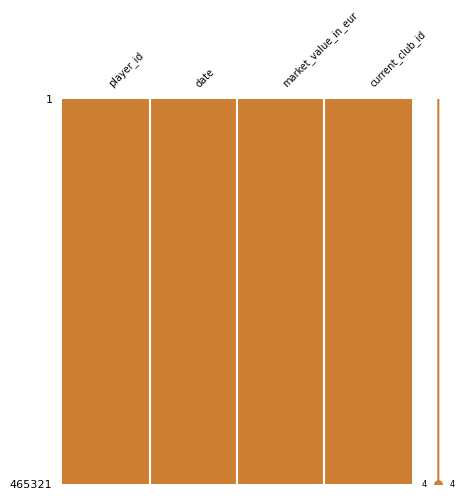

In [335]:
# 결측치 확인
null_check(player_value)

### games data

In [398]:
# 데이터 확인
games_data = games.drop(['competition_id', 'season', 'round', 'home_club_position', 'away_club_position', 'home_club_manager_name', 'away_club_manager_name', 'referee', 'stadium', 'attendance', 'url', 'home_club_name', 'away_club_name', 'aggregate', 'competition_type'], axis = 1).sort_values(by = 'date')
games_data

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_formation,away_club_formation
13042,2234412,2012-07-03,24832,10694,0,6,NaN,NaN
9313,2235764,2012-07-03,1167,5594,0,0,NaN,NaN
41321,2231978,2012-07-03,853,10747,7,0,NaN,NaN
45069,2231982,2012-07-03,6335,28958,8,0,NaN,NaN
13037,2231979,2012-07-03,3471,10532,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
63801,4243722,2024-02-22,415,294,0,0,3-4-2-1,4-2-3-1
26737,4243721,2024-02-22,336,452,1,1,3-4-3,4-2-3-1
46119,4243719,2024-02-22,273,5,3,2,4-3-3 Attacking,4-2-3-1
58444,4243723,2024-02-22,10625,1075,2,3,4-2-3-1,4-4-2


[ 결측치 확인 ]

-----------------------------------
home_club_formation 결측치 비율:
9.4 %
-----------------------------------
away_club_formation 결측치 비율:
9.18 %
-----------------------------------


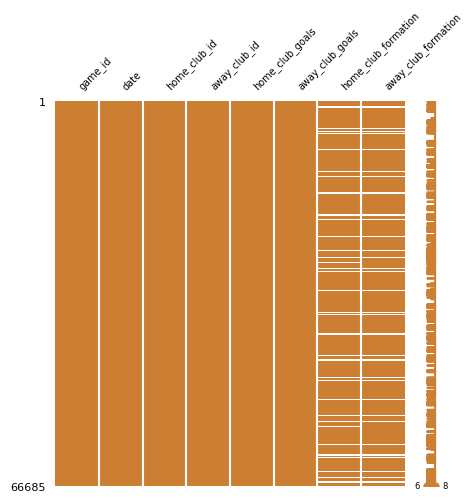

In [337]:
null_check(games_data)

### game event data

In [338]:
# 데이터 확인
events = game_events.drop(['game_event_id', 'minute', 'description', 'player_in_id'], axis = 1)
events = events[events['type'] != 'Substitutions']

assist = events.player_assist_id.mask(events.player_assist_id > 0, 'assist')

assist_temp = pd.DataFrame({'date' : events.date,
                       'game_id' : events.game_id,
                       'type' : assist,
                       'club_id' : events.club_id,
                       'player_id' : events.player_assist_id.values})
assist_data = assist_temp.dropna(axis = 0)

events_data = pd.concat((events.drop(['player_assist_id'], axis = 1), assist_data), ignore_index = True, sort = False)
events_data = events_data.sort_values(by = 'date')
events_data = events_data.reset_index(drop = True)

events_data

,date,game_id,type,club_id,player_id
0,2012-07-03,2231978,Goals,853,38004.0
1,2012-07-03,2231978,Goals,853,21679.0
2,2012-07-03,2231978,Goals,853,21679.0
3,2012-07-03,2231978,assist,853,79860.0
4,2012-07-03,2231978,assist,853,82883.0
...,...,...,...,...,...
289205,2024-02-22,4243719,Goals,273,266359.0
289206,2024-02-22,4243719,Goals,273,266359.0
289207,2024-02-22,4243719,Goals,5,357164.0
289208,2024-02-22,4243719,Cards,5,48859.0


In [339]:
events_data.type.unique()

array(['Goals', 'assist', 'Cards', 'Shootout'], dtype=object)

[ 결측치 확인 ]

-----------------------------------


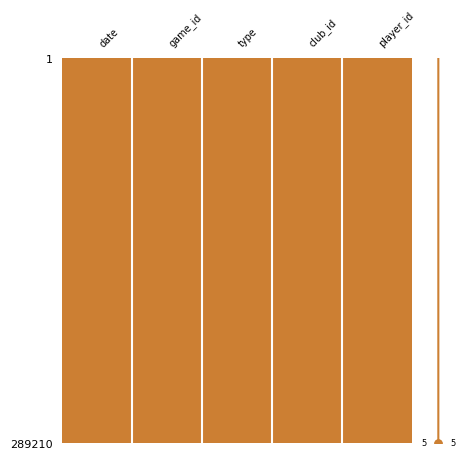

In [340]:
null_check(events_data)

## EDA for merged dataset

### merge

#### events data 준비

- events_data 에서 club_id가 현재 club이 아닌 게임 당시의 club으로 표시된 것인지 확인
    - 아래에서 동일한 선수(38004)에 대해 여러개의 club_id(4개)가 할당되어 있으므로 club_id 컬럼은 해당 date 또는 해당 game에서 뛰었던 선수의 그 당시 club을 나타내고 있음을 알 수 있다.

In [341]:
events_data

,date,game_id,type,club_id,player_id
0,2012-07-03,2231978,Goals,853,38004.0
1,2012-07-03,2231978,Goals,853,21679.0
2,2012-07-03,2231978,Goals,853,21679.0
3,2012-07-03,2231978,assist,853,79860.0
4,2012-07-03,2231978,assist,853,82883.0
...,...,...,...,...,...
289205,2024-02-22,4243719,Goals,273,266359.0
289206,2024-02-22,4243719,Goals,273,266359.0
289207,2024-02-22,4243719,Goals,5,357164.0
289208,2024-02-22,4243719,Cards,5,48859.0


In [342]:
events_data[events_data.player_id == 38004.0].club_id.unique()

array([853, 403, 202, 235], dtype=int64)

In [ ]:
events_data_grouped.type.unique()

In [350]:
events_data_temp = events_data.drop(['player_id'], axis = 1)

event_list = events_data_temp.type.unique()

for i in range(len(event_list)):
    temp_event = np.where(events_data_temp.type.values == event_list[i], 1, np.NaN)
    events_data_temp[event_list[i]] = temp_event

events_data_grouped_temp = events_data_temp.drop(['type'], axis = 1).groupby(['game_id', 'club_id', 'date']).count()
events_data_grouped = events_data_grouped_temp.reset_index().sort_values(by = 'date').set_index('date', drop = True)
events_data_grouped

,game_id,club_id,Goals,assist,Cards,Shootout
date,,,,,,
2012-07-03,2235764,5594,0,0,1,0
2012-07-03,2231982,28958,0,0,2,0
2012-07-03,2231982,6335,8,7,0,0
2012-07-03,2235764,1167,0,0,1,0
2012-07-03,2234412,10694,6,6,0,0
...,...,...,...,...,...,...
2024-02-22,4243719,5,2,1,2,0
2024-02-22,4243718,234,1,0,4,4
2024-02-22,4243718,12,1,1,3,5


In [345]:
# club 수 확인
len(events_data_grouped.club_id.unique())

2350

In [508]:
window = 5

events_dataset = pd.DataFrame({'game_id' : np.NaN,
                               'club_id' : np.NaN,
                               'Goals' : np.NaN,
                              'assist' : np.NaN,
                              'Cards' : np.NaN}, index = [0])
events_dataset.index.name = 'date'

club_list = events_data_grouped.club_id.unique()

# 각 event type에 대해 직전 5개 경기의 이동평균값으로 대체
for i in range(len(club_list)):
    
    temp_df_1 = events_data_grouped[events_data_grouped.club_id == club_list[i]]

    temp_df_2 = pd.DataFrame({'Goals' : temp_df_1.Goals,
                             'assist' : temp_df_1.assist,
                             'Cards' : temp_df_1.Cards})
    
    temp_df_shifted = temp_df_2.shift(axis = 0, fill_value = np.nan)
    
    temp_rolling = temp_df_shifted.rolling(window).mean()
    temp_df_3 = temp_df_1.drop(['Goals', 'assist', 'Cards', 'Shootout'], axis = 1)
    temp_finish = temp_df_3.join(temp_rolling, how = 'left')

    events_dataset = pd.concat((events_dataset, temp_finish), sort = False)
    
events_dataset = events_dataset.drop(index = 0).sort_values(by = 'date')
events_dataset

,game_id,club_id,Goals,assist,Cards
date,,,,,
2012-07-03,2235764.0,5594.0,NaN,NaN,NaN
2012-07-03,2234412.0,10694.0,NaN,NaN,NaN
2012-07-03,2231979.0,10532.0,NaN,NaN,NaN
2012-07-03,2231978.0,853.0,NaN,NaN,NaN
2012-07-03,2235764.0,1167.0,NaN,NaN,NaN
...,...,...,...,...,...
2024-02-22,4243721.0,452.0,1.0,0.6,2.8
2024-02-22,4243720.0,60.0,1.6,1.0,2.0
2024-02-22,4243724.0,141.0,2.4,1.8,1.6


- 한계점: 위와 같이 처리할 경우 각 클럽의 맨 앞 5개 데이터는 NaN값으로 처리되며, 클럽 당 게임 수가 5이하인 클럽은 모두 NaN값으로 처리됨. 해당 NaN값들은 차후 전처리 필요

In [509]:
temp_club_count = pd.DataFrame(events_data_grouped.club_id.value_counts() < 6)
print("클럽 당 게임 수가 5 이하인 경우 : ", temp_club_count.value_counts())
print(temp_club_count)

클럽 당 게임 수가 5 이하인 경우 :  count
False    1221
True     1129
Name: count, dtype: int64
         count
club_id       
131      False
418      False
281      False
27       False
506      False
...        ...
4096      True
345       True
4113      True
21934     True
726       True

[2350 rows x 1 columns]


In [510]:
# club 수 확인
len(events_dataset.club_id.unique())

2350

#### game data 준비

In [511]:
games_data

,game_id,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_formation,away_club_formation
13042,2234412,2012-07-03,24832,10694,0,6,NaN,NaN
9313,2235764,2012-07-03,1167,5594,0,0,NaN,NaN
41321,2231978,2012-07-03,853,10747,7,0,NaN,NaN
45069,2231982,2012-07-03,6335,28958,8,0,NaN,NaN
13037,2231979,2012-07-03,3471,10532,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
63801,4243722,2024-02-22,415,294,0,0,3-4-2-1,4-2-3-1
26737,4243721,2024-02-22,336,452,1,1,3-4-3,4-2-3-1
46119,4243719,2024-02-22,273,5,3,2,4-3-3 Attacking,4-2-3-1
58444,4243723,2024-02-22,10625,1075,2,3,4-2-3-1,4-4-2


In [512]:
games_data.home_club_formation.isna().sum()

6271

In [513]:
games_data.columns

Index(['game_id', 'date', 'home_club_id', 'away_club_id', 'home_club_goals',
       'away_club_goals', 'home_club_formation', 'away_club_formation'],
      dtype='object')

In [514]:
games_data.date

13042    2012-07-03
9313     2012-07-03
41321    2012-07-03
45069    2012-07-03
13037    2012-07-03
            ...    
63801    2024-02-22
26737    2024-02-22
46119    2024-02-22
58444    2024-02-22
10408    2024-02-22
Name: date, Length: 66685, dtype: object

#### merge

In [515]:
temp_home = games_data.drop(['away_club_id', 'away_club_goals', 'away_club_formation'], axis = 1)
temp_away = games_data.drop(['home_club_id', 'home_club_goals', 'home_club_formation'], axis = 1)

temp_home.columns = ['game_id', 'date', 'club_id', 'home_club_goals', 'home_club_formation']
temp_away.columns = ['game_id', 'date', 'club_id', 'away_club_goals', 'away_club_formation']

temp_home = pd.merge(temp_home, events_dataset, on = ["game_id", "club_id"], how = "left")
temp_away = pd.merge(temp_away, events_dataset, on = ["game_id", "club_id"], how = "left")

temp_home.columns = ['game_id', 'date', 'home_club_id', 'home_club_goals', 'home_club_formation', 'pre_home_goals', 'pre_home_assist', 'pre_home_cards']
temp_away.columns = ['game_id', 'date', 'away_club_id', 'away_club_goals', 'away_club_formation', 'pre_away_goals', 'pre_away_assist', 'pre_away_cards']

print(temp_home)
print(temp_away)

       game_id        date  home_club_id  home_club_goals home_club_formation  \
0      2234412  2012-07-03         24832                0                 NaN   
1      2235764  2012-07-03          1167                0                 NaN   
2      2231978  2012-07-03           853                7                 NaN   
3      2231982  2012-07-03          6335                8                 NaN   
4      2231979  2012-07-03          3471                0                 NaN   
...        ...         ...           ...              ...                 ...   
66680  4243722  2024-02-22           415                0             3-4-2-1   
66681  4243721  2024-02-22           336                1               3-4-3   
66682  4243719  2024-02-22           273                3     4-3-3 Attacking   
66683  4243723  2024-02-22         10625                2             4-2-3-1   
66684  4243720  2024-02-22            60                3               3-4-3   

       pre_home_goals  pre_

#### result column 추가

In [516]:
print("home club goals 결측치 수 : ", temp_home.home_club_goals.isna().sum())
print("away club goals 결측치 수 : ", temp_away.away_club_goals.isna().sum())

home club goals 결측치 수 :  0
away club goals 결측치 수 :  0


In [517]:
dataset = pd.merge(temp_home, temp_away, on = ["game_id", "date"], how = "inner")

result = []

for home, away in zip(dataset.home_club_goals.values, dataset.away_club_goals.values):
    if home > away:
        result.append("home")
    elif away > home:
        result.append("away")
    else:
        result.append("draw")
        
dataset['result'] = result
dataset = dataset.drop(["home_club_goals", "away_club_goals"], axis = 1)
dataset

,game_id,date,home_club_id,home_club_formation,pre_home_goals,pre_home_assist,pre_home_cards,away_club_id,away_club_formation,pre_away_goals,pre_away_assist,pre_away_cards,result
0,2234412,2012-07-03,24832,NaN,NaN,NaN,NaN,10694,NaN,NaN,NaN,NaN,away
1,2235764,2012-07-03,1167,NaN,NaN,NaN,NaN,5594,NaN,NaN,NaN,NaN,draw
2,2231978,2012-07-03,853,NaN,NaN,NaN,NaN,10747,NaN,NaN,NaN,NaN,home
3,2231982,2012-07-03,6335,NaN,NaN,NaN,NaN,28958,NaN,NaN,NaN,NaN,home
4,2231979,2012-07-03,3471,NaN,NaN,NaN,NaN,10532,NaN,NaN,NaN,NaN,draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66680,4243722,2024-02-22,415,3-4-2-1,1.4,0.6,3.6,294,4-2-3-1,3.4,2.8,1.2,draw
66681,4243721,2024-02-22,336,3-4-3,3.6,2.6,0.8,452,4-2-3-1,1.0,0.6,2.8,draw
66682,4243719,2024-02-22,273,4-3-3 Attacking,1.8,1.4,1.8,5,4-2-3-1,2.2,1.8,2.2,home
66683,4243723,2024-02-22,10625,4-2-3-1,1.8,1.0,2.6,1075,4-4-2,1.4,0.6,2.2,away


### 결측치 확인

[ 결측치 확인 ]

-----------------------------------
home_club_formation 결측치 비율:
9.4 %
-----------------------------------
pre_home_goals 결측치 비율:
26.58 %
-----------------------------------
pre_home_assist 결측치 비율:
26.58 %
-----------------------------------
pre_home_cards 결측치 비율:
26.58 %
-----------------------------------
away_club_formation 결측치 비율:
9.18 %
-----------------------------------
pre_away_goals 결측치 비율:
31.07 %
-----------------------------------
pre_away_assist 결측치 비율:
31.07 %
-----------------------------------
pre_away_cards 결측치 비율:
31.07 %
-----------------------------------


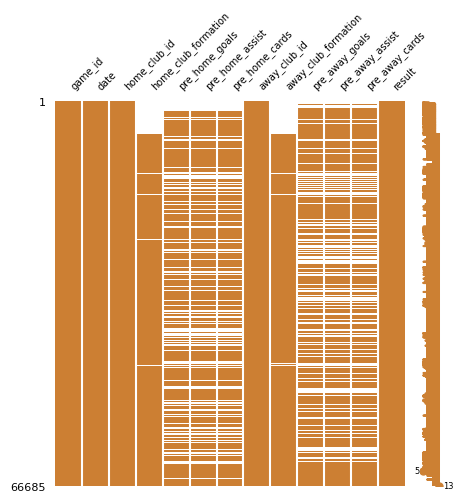

In [518]:
null_check(dataset)

### 범주형자료

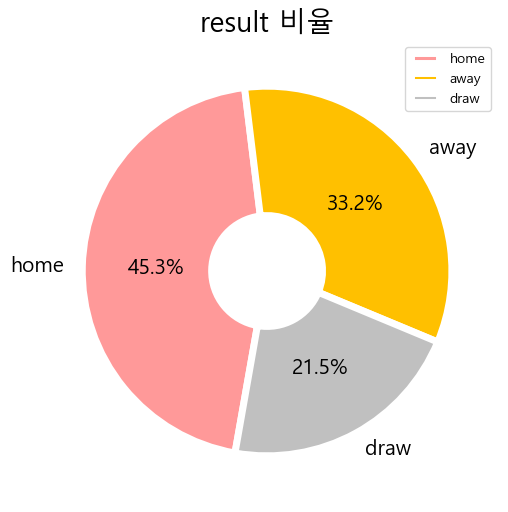

In [545]:
pie(dataset.result)

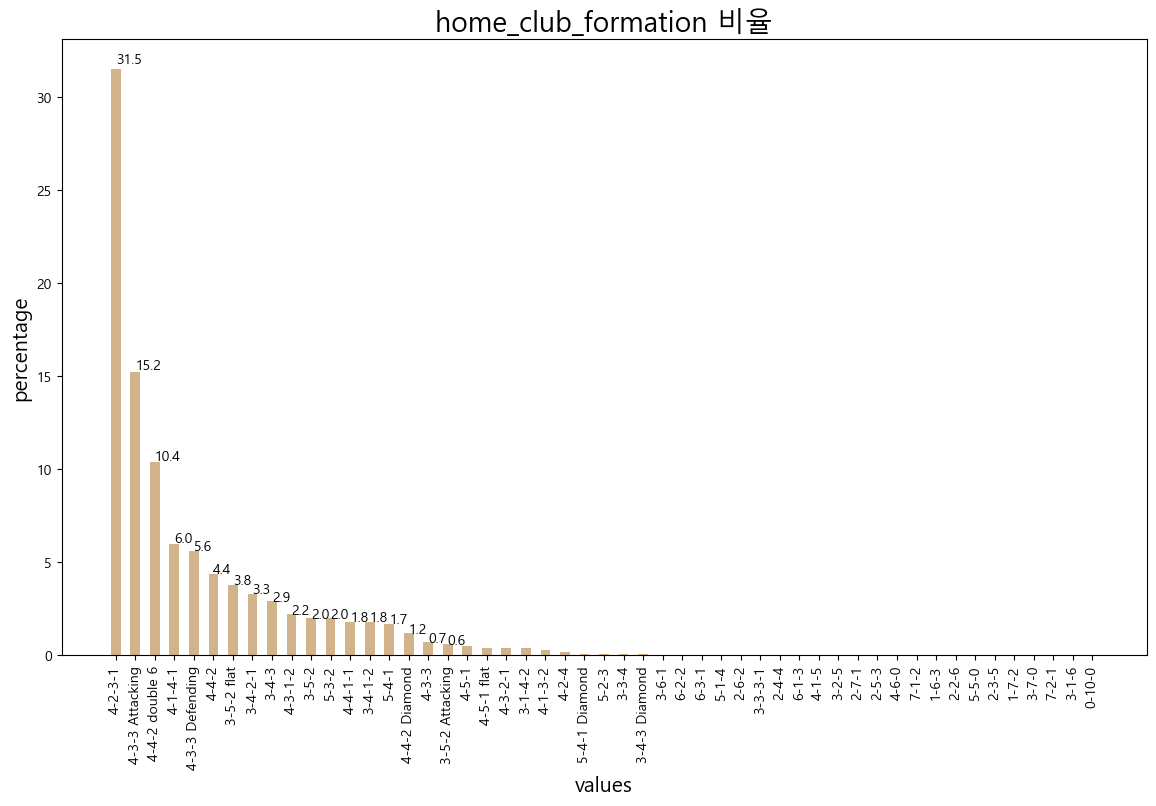

In [600]:
bar(dataset.home_club_formation)

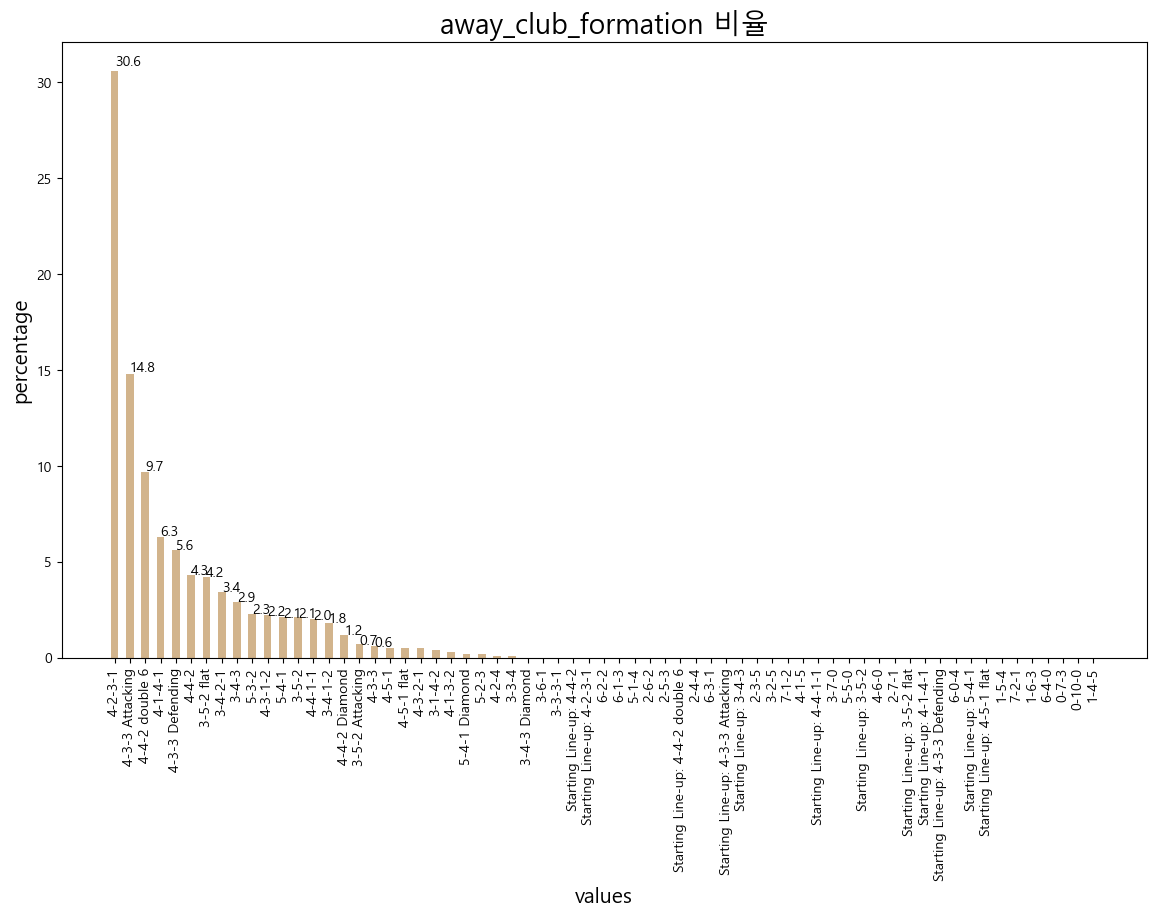

In [601]:
bar(dataset.away_club_formation)

### 수치형 자료

#### 정규성

C:\Users\LG\AppData\Local\Temp\ipykernel_16332\1260687035.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, kde = False, fit=norm)


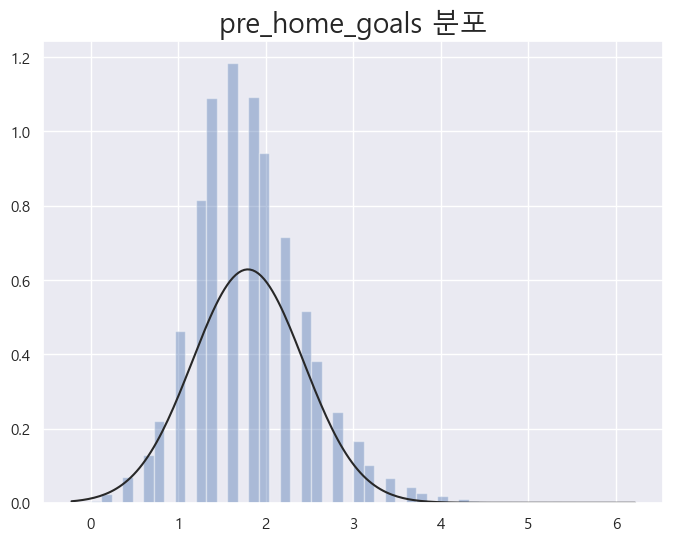

In [666]:
dist(dataset.pre_home_goals)

C:\Users\LG\AppData\Local\Temp\ipykernel_16332\1260687035.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, kde = False, fit=norm)


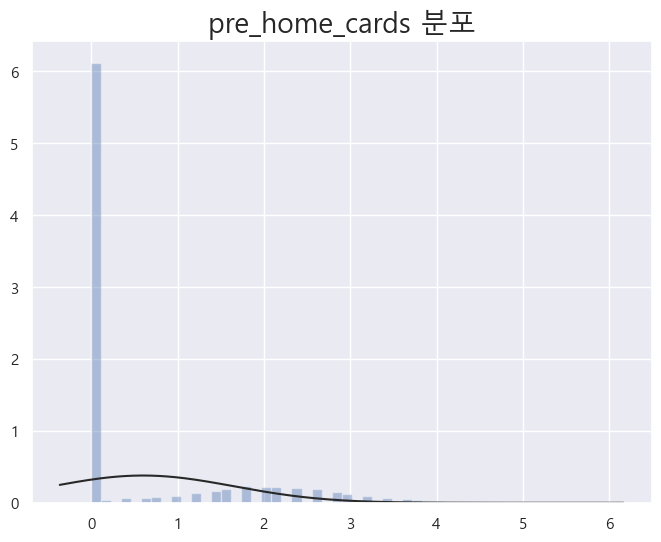

In [667]:
dist(dataset.pre_home_cards)

#### 이상치

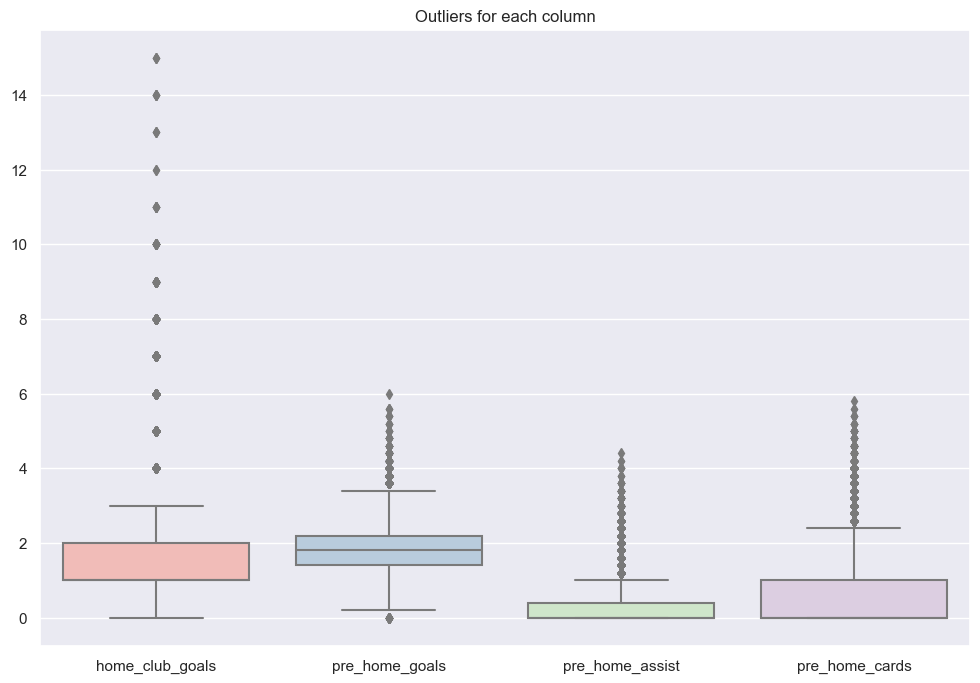

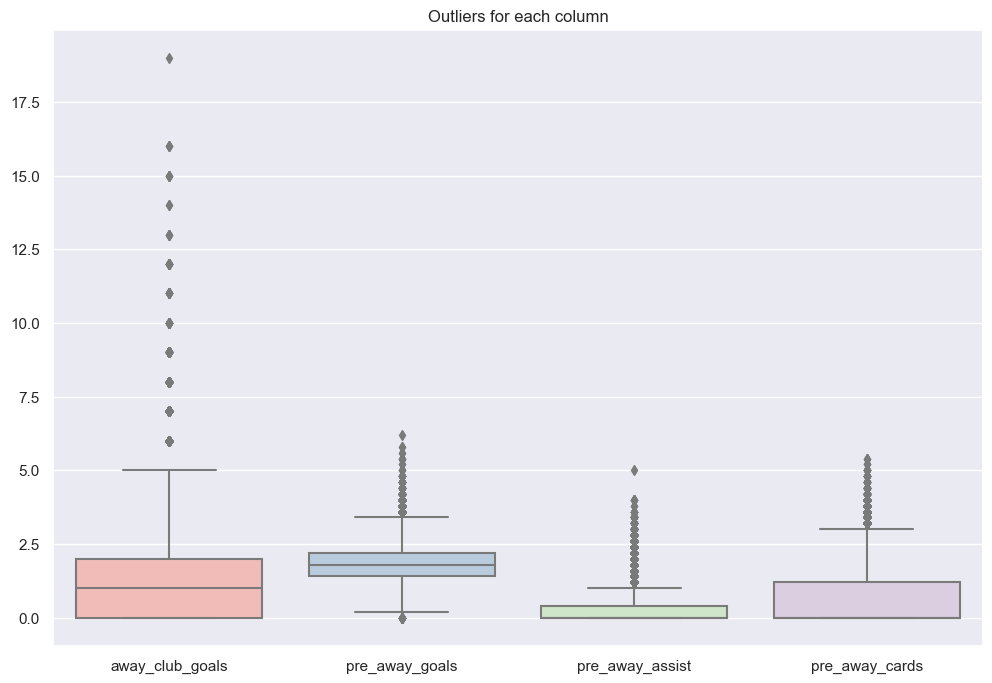

In [685]:
eda_home = temp_home.drop(['game_id','date','home_club_id','home_club_formation'], axis = 1)
eda_away = temp_away.drop(['game_id','date','away_club_id','away_club_formation'], axis = 1)
outlier(eda_home)
outlier(eda_away)